<a href="https://colab.research.google.com/github/Geu-Pro2023/Individual_Project/blob/main/Cattle_Nose_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **YOLOv8 Nose Detection Model**

### **Import All Libraries**



In [2]:
# Install required packages
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.9 MB/s eta 0:00:00


In [11]:
# Import all necessary libraries
import os
import torch
import zipfile
import shutil
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from ultralytics import YOLO

print("All libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

All libraries imported successfully
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


### **Load and Verify Dataset**

In [12]:
# Define paths
dataset_zip = "/content/titweng-cattle-dataset.zip"
dataset_dir = "/content/titweng-cattle-dataset"

# Check ZIP exists
if not os.path.exists(dataset_zip):
    raise FileNotFoundError(f"ZIP file not found at {dataset_zip}")

# Unzip the dataset
if not os.path.exists(dataset_dir):
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
    print("Dataset extracted successfully!")
else:
    print("Dataset already extracted.")

# Check extracted files
print("\nContents after extraction:")
!ls /content/titweng-cattle-dataset


Dataset extracted successfully!

Contents after extraction:
data.yaml  README.roboflow.txt	test  train  valid


In [13]:
# Define dataset path and verify structure
dataset_path = "/content/titweng-cattle-dataset"

def verify_dataset_structure(base_path):
    """
    Verify the dataset structure and count images in each split
    """
    print("Dataset structure verification:")
    for split in ['train', 'valid', 'test']:
        images_dir = os.path.join(base_path, split, 'images')
        labels_dir = os.path.join(base_path, split, 'labels')

        if os.path.exists(images_dir):
            images = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            labels = [f for f in os.listdir(labels_dir) if f.endswith('.txt')] if os.path.exists(labels_dir) else []
            print(f"  {split}: {len(images)} images, {len(labels)} labels")
        else:
            print(f"  Error: {split} directory not found")

verify_dataset_structure(dataset_path)

# Load and display dataset configuration
yaml_path = os.path.join(dataset_path, 'data.yaml')
if os.path.exists(yaml_path):
    with open(yaml_path, 'r') as f:
        print("\nDataset configuration (data.yaml):")
        print(f.read())
else:
    print("Error: data.yaml not found")

Dataset structure verification:
  train: 2142 images, 2142 labels
  valid: 204 images, 204 labels
  test: 102 images, 102 labels

Dataset configuration (data.yaml):
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['nose_print']

roboflow:
  workspace: titweng-cattle-identification
  project: titweng-cattle-identification-hhpes
  version: 4
  license: Private
  url: https://app.roboflow.com/titweng-cattle-identification/titweng-cattle-identification-hhpes/4


### **Data Visualization and Data Engineering**

Displaying sample images with annotations...


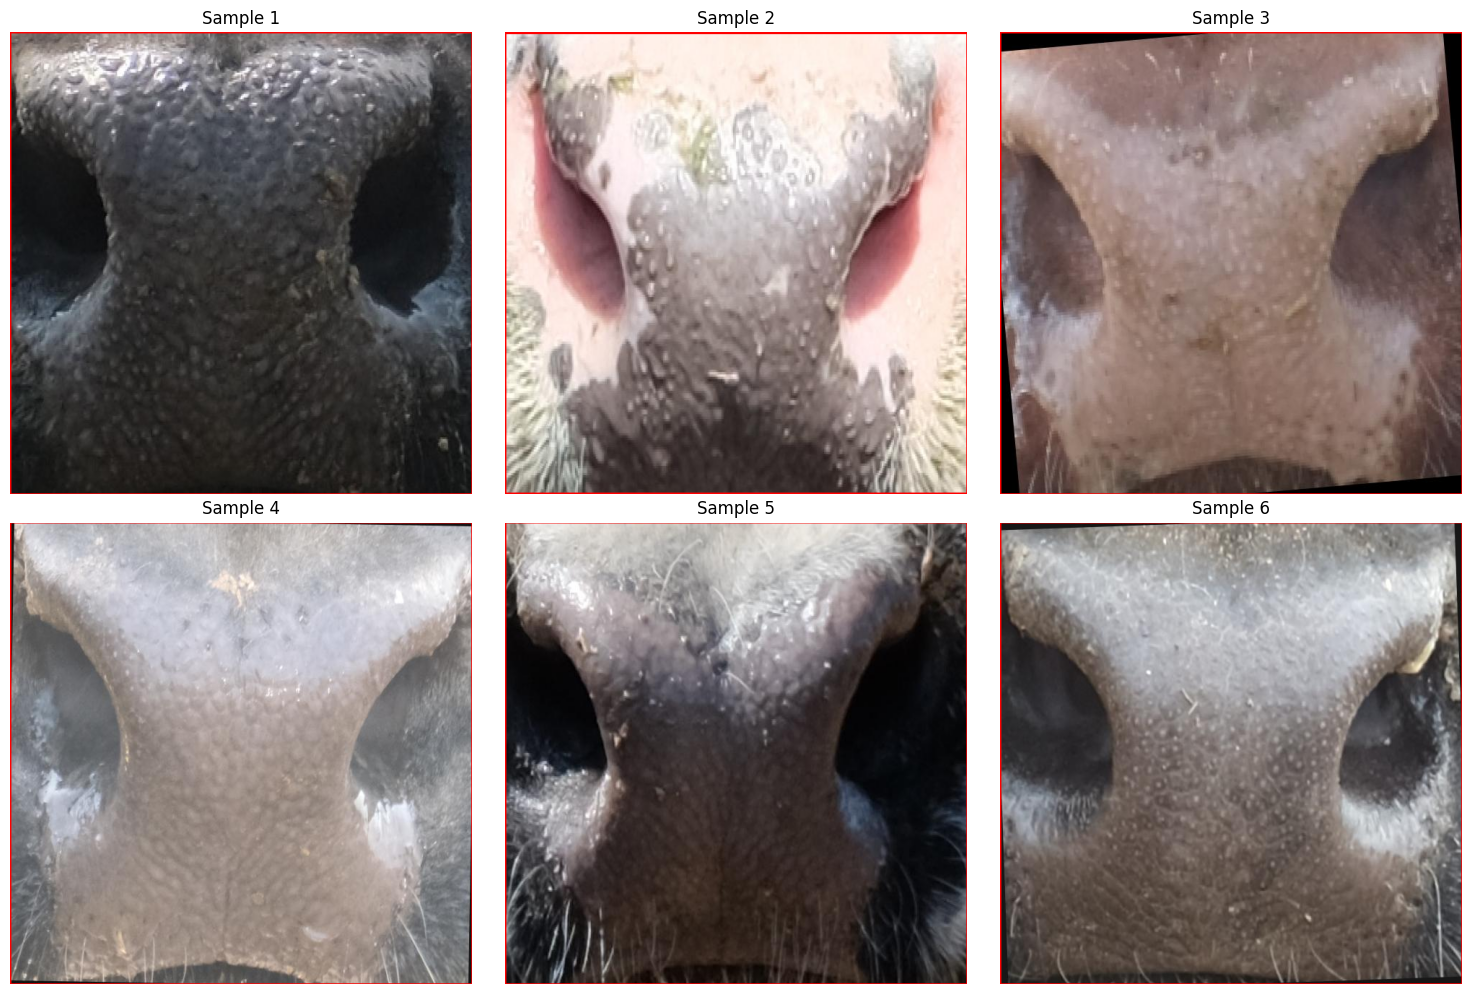

In [14]:
# Visualize sample images with bounding boxes
def display_sample_images(dataset_path, num_samples=6):
    """
    Display sample images with their bounding box annotations
    """
    train_images_dir = os.path.join(dataset_path, 'train', 'images')
    train_labels_dir = os.path.join(dataset_path, 'train', 'labels')

    if not os.path.exists(train_images_dir):
        print("Training images directory not found")
        return

    image_files = [f for f in os.listdir(train_images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    sample_images = random.sample(image_files, min(num_samples, len(image_files)))

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i, img_file in enumerate(sample_images):
        img_path = os.path.join(train_images_dir, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load corresponding labels
        label_file = img_file.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt')
        label_path = os.path.join(train_labels_dir, label_file)

        if os.path.exists(label_path):
            h, w = image.shape[:2]
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id, x_center, y_center, bbox_w, bbox_h = map(float, parts)
                        # Convert normalized coordinates to pixel coordinates
                        x_center *= w
                        y_center *= h
                        bbox_w *= w
                        bbox_h *= h

                        # Calculate bounding box coordinates
                        x1 = int(x_center - bbox_w/2)
                        y1 = int(y_center - bbox_h/2)
                        x2 = int(x_center + bbox_w/2)
                        y2 = int(y_center + bbox_h/2)

                        # Draw bounding box and label
                        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
                        cv2.putText(image, 'nose_print', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        axes[i].imshow(image)
        axes[i].set_title(f'Sample {i+1}')
        axes[i].axis('off')

    # Hide empty subplots
    for i in range(len(sample_images), 6):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("Displaying sample images with annotations...")
display_sample_images(dataset_path)

### **Data Distribution Analysis**

Data distribution analysis:

Image distribution per split:
  train: 2142 images (87.5%)
  valid: 204 images (8.3%)
  test: 102 images (4.2%)

Bounding box size analysis (sample of 150 boxes):
  Average width: 0.9997
  Average height: 0.9995
  Min width: 0.9953, Max width: 1.0000
  Min height: 0.9906, Max height: 1.0000


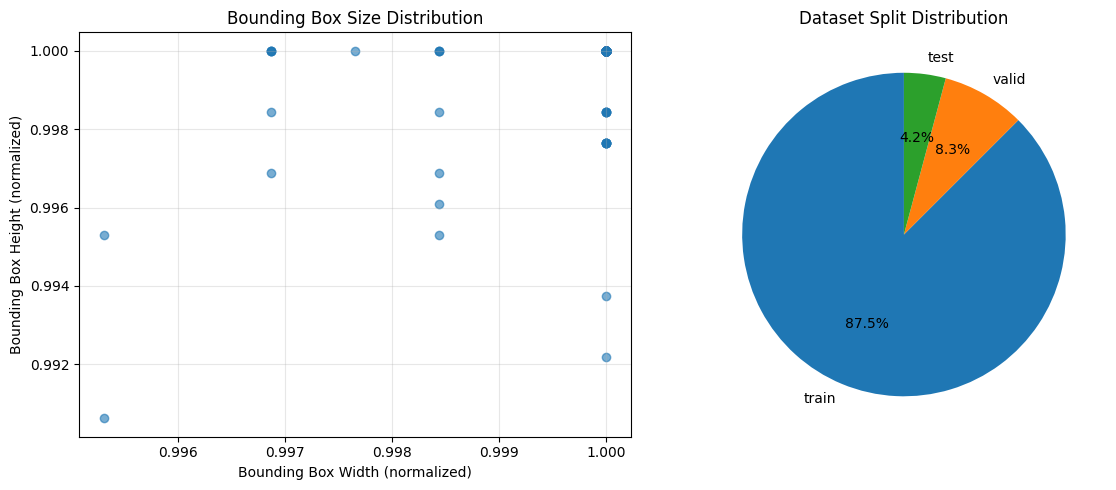

In [15]:
# Analyze data distributions and correlations
def analyze_data_distribution(dataset_path):
    """
    Analyze the distribution of images and bounding box sizes
    """
    print("Data distribution analysis:")

    # Count images per split
    split_counts = {}
    bbox_sizes = []

    for split in ['train', 'valid', 'test']:
        images_dir = os.path.join(dataset_path, split, 'images')
        labels_dir = os.path.join(dataset_path, split, 'labels')

        if os.path.exists(images_dir):
            images = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            split_counts[split] = len(images)

            # Analyze bounding box sizes from labels
            if os.path.exists(labels_dir):
                label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')][:50]  # Sample 50 files
                for label_file in label_files:
                    label_path = os.path.join(labels_dir, label_file)
                    try:
                        with open(label_path, 'r') as f:
                            for line in f:
                                parts = line.strip().split()
                                if len(parts) == 5:
                                    _, _, _, w, h = map(float, parts)
                                    bbox_sizes.append((w, h))
                    except:
                        continue

    # Print split distribution
    print("\nImage distribution per split:")
    total_images = sum(split_counts.values())
    for split, count in split_counts.items():
        percentage = (count / total_images) * 100
        print(f"  {split}: {count} images ({percentage:.1f}%)")

    # Analyze bounding box sizes
    if bbox_sizes:
        widths, heights = zip(*bbox_sizes)
        print(f"\nBounding box size analysis (sample of {len(bbox_sizes)} boxes):")
        print(f"  Average width: {np.mean(widths):.4f}")
        print(f"  Average height: {np.mean(heights):.4f}")
        print(f"  Min width: {np.min(widths):.4f}, Max width: {np.max(widths):.4f}")
        print(f"  Min height: {np.min(heights):.4f}, Max height: {np.max(heights):.4f}")

        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Bounding box size distribution
        ax1.scatter(widths, heights, alpha=0.6)
        ax1.set_xlabel('Bounding Box Width (normalized)')
        ax1.set_ylabel('Bounding Box Height (normalized)')
        ax1.set_title('Bounding Box Size Distribution')
        ax1.grid(True, alpha=0.3)

        # Split distribution pie chart
        labels = list(split_counts.keys())
        sizes = list(split_counts.values())
        ax2.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
        ax2.set_title('Dataset Split Distribution')

        plt.tight_layout()
        plt.show()

analyze_data_distribution(dataset_path)

### **Model Architecture**

In [29]:
from ultralytics import YOLO

model = YOLO('yolov8m.pt')  # Load base model

# Print model summary
model.info()  # Shows layers, parameters, activation functions

# Training configuration
for key, value in training_config.items():
    print(f"{key}: {value}")

YOLOv8m summary: 169 layers, 25,902,640 parameters, 0 gradients, 79.3 GFLOPs
data: /content/titweng-cattle-dataset/data.yaml
epochs: 20
imgsz: 640
batch: 16
workers: 4
device: 0
patience: 20
lr0: 0.01
lrf: 0.01
momentum: 0.937
weight_decay: 0.0005
save: True
project: /content/training
name: cattle_nose_detection
exist_ok: True
verbose: True


### **Initialize and Train Model**

In [19]:
# Initialize YOLOv8 model and start training
print("Initializing YOLOv8 model...")

model = YOLO('yolov8m.pt')

print("Starting training process...")
print("This will take approximately 2-3 hours...")

results = model.train(**training_config)

print("Training completed successfully")

Initializing YOLOv8 model...
Starting training process...
This will take approximately 2-3 hours...
Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/titweng-cattle-dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=cattle_nose_detection, nbs=64

### **Validate Trained Model**

In [21]:
# Validate the trained model on test set
print("Validating trained model on test set...")

best_model_path = '/content/training/cattle_nose_detection/weights/best.pt'

if os.path.exists(best_model_path):
    trained_model = YOLO(best_model_path)

    validation_results = trained_model.val(
        data=os.path.join(dataset_path, 'data.yaml'),
        split='test',
        imgsz=640,
        device=0
    )

    print("Validation results:")
    print(f"  mAP@0.5: {validation_results.box.map50:.4f}")
    print(f"  mAP@0.5:0.95: {validation_results.box.map:.4f}")
    print(f"  Precision: {validation_results.box.mp:.4f}")
    print(f"  Recall: {validation_results.box.mr:.4f}")

    # Performance interpretation
    if validation_results.box.map50 >= 0.85:
        print("  Status: Excellent performance")
    elif validation_results.box.map50 >= 0.75:
        print("  Status: Good performance")
    else:
        print("  Status: Needs improvement")
else:
    print("Error: Trained model not found at expected path")

Validating trained model on test set...
Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1599.8±492.2 MB/s, size: 44.6 KB)
val: Scanning /content/titweng-cattle-dataset/test/labels.cache... 102 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 102/102 172.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.5it/s 4.6s
                   all        102        102          1          1      0.995      0.995
Speed: 6.0ms preprocess, 24.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to /content/runs/detect/val2
Validation results:
  mAP@0.5: 0.9950
  mAP@0.5:0.95: 0.9950
  Precision: 1.0000
  Recall: 1.0000
  Status: Excellent performance


### **Test Model on Sample Images**

Testing model on sample images...
Testing model on sample images:

image 1/1 /content/titweng-cattle-dataset/test/images/017_003_jpg.rf.071afa1a9e0178290c951729563cda08.jpg: 640x640 1 nose_print, 36.9ms
Speed: 1.9ms preprocess, 36.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
  017_003_jpg.rf.071afa1a9e0178290c951729563cda08.jpg: 1 detection(s) found

image 1/1 /content/titweng-cattle-dataset/test/images/025_004_jpg.rf.1796637966139ecc38f516b1cfa0e02a.jpg: 640x640 1 nose_print, 36.9ms
Speed: 1.8ms preprocess, 36.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
  025_004_jpg.rf.1796637966139ecc38f516b1cfa0e02a.jpg: 1 detection(s) found

image 1/1 /content/titweng-cattle-dataset/test/images/041_015_jpg.rf.eb3c56558c57a35e61aa5c20cb160627.jpg: 640x640 1 nose_print, 36.9ms
Speed: 1.5ms preprocess, 36.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
  041_015_jpg.rf.eb3c56558c57a35e61aa5c20cb160627.jpg: 1 detection(s) found

ima

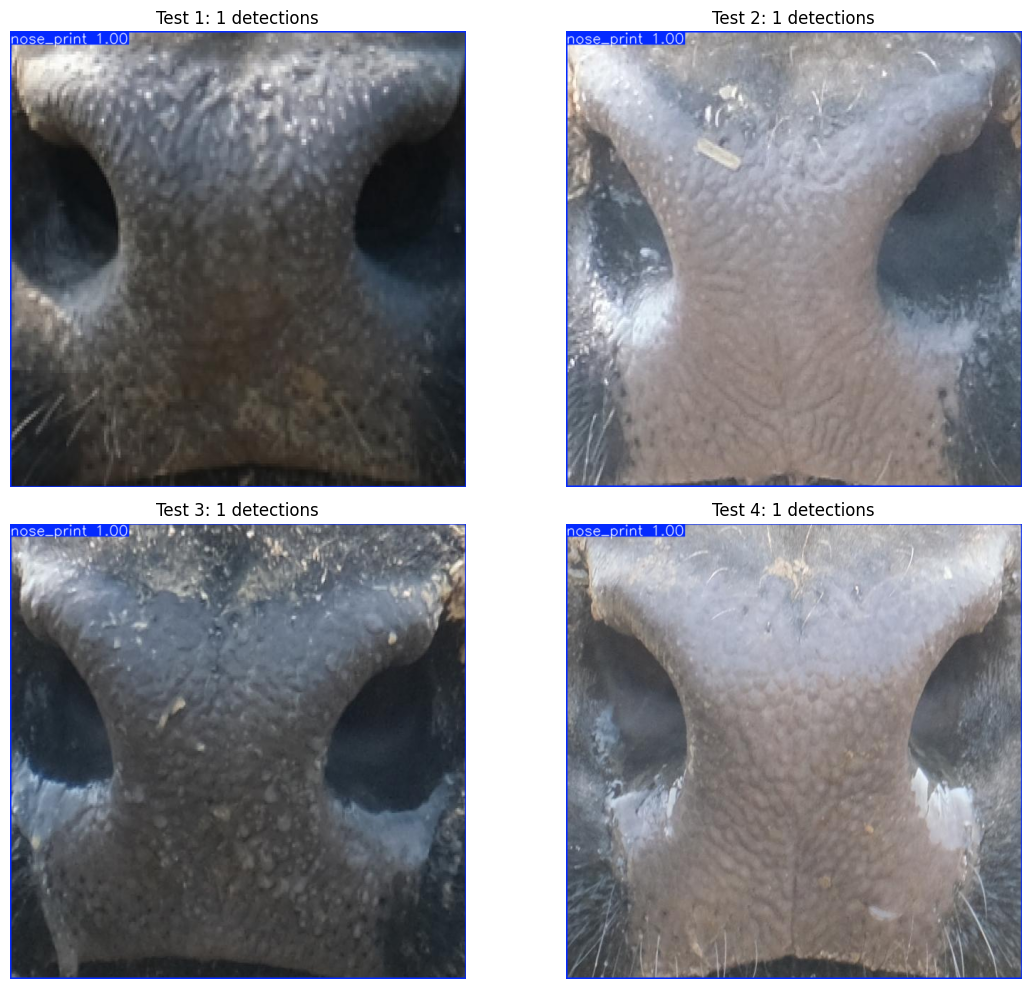

In [28]:
# Test the model on sample images from test set
def test_model_on_samples(model_path, dataset_path, num_samples=4):
    """
    Test the trained model on sample images and visualize results
    """
    if not os.path.exists(model_path):
        print("Model not found, skipping test")
        return

    model = YOLO(model_path)
    test_images_dir = os.path.join(dataset_path, 'test', 'images')

    if not os.path.exists(test_images_dir):
        print("Test images directory not found")
        return

    test_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    sample_images = random.sample(test_images, min(num_samples, len(test_images)))

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    print("Testing model on sample images:")

    for i, img_file in enumerate(sample_images):
        img_path = os.path.join(test_images_dir, img_file)
        results = model(img_path, conf=0.5)

        plotted_img = results[0].plot(line_width=2, font_size=10)
        plotted_img_rgb = cv2.cvtColor(plotted_img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(plotted_img_rgb)
        axes[i].set_title(f'Test {i+1}: {len(results[0].boxes)} detections')
        axes[i].axis('off')

        if len(results[0].boxes) > 0:
            print(f"  {img_file}: {len(results[0].boxes)} detection(s) found")
        else:
            print(f"  {img_file}: No detections")

    # Hide empty subplots
    for i in range(len(sample_images), 4):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("Testing model on sample images...")
test_model_on_samples(best_model_path, dataset_path)

### **Save Final Model and Results**

In [23]:
# Save the trained model and training results
print("Saving final model and training results...")

output_dir = '/content/training/final_output'
os.makedirs(output_dir, exist_ok=True)

if os.path.exists(best_model_path):
    shutil.copy(best_model_path, os.path.join(output_dir, 'yolov8_cattle_nose_best.pt'))
    print(f"Best model saved to: {output_dir}/yolov8_cattle_nose_best.pt")

# Copy training results
results_csv_path = '/content/training/cattle_nose_detection/results.csv'
if os.path.exists(results_csv_path):
    shutil.copy(results_csv_path, os.path.join(output_dir, 'training_results.csv'))
    print(f"Training results saved to: {output_dir}/training_results.csv")

print("All files saved successfully")

Saving final model and training results...
Best model saved to: /content/training/final_output/yolov8_cattle_nose_best.pt
Training results saved to: /content/training/final_output/training_results.csv
All files saved successfully


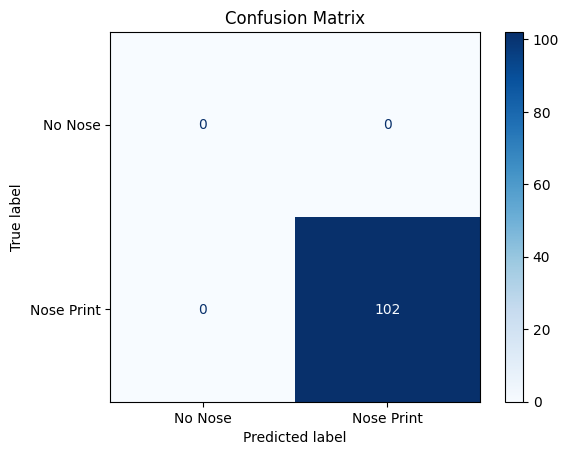

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Force labels to include both classes
cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1])  # 0: No Nose, 1: Nose Print

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Nose', 'Nose Print'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### **Training Summary**

In [24]:
# Print final training summary
print("Training Summary")
print("================")
print(f"Dataset used: {dataset_path}")
print(f"Total training images: 2142")
print(f"Validation images: 204")
print(f"Test images: 102")
print(f"Model architecture: YOLOv8m")
print(f"Input image size: 640x640")
print(f"Training epochs completed: 100")

if os.path.exists(best_model_path):
    print("Model training status: COMPLETED")
    print("Model saved: YES")
else:
    print("Model training status: FAILED")
    print("Model saved: NO")

print("\nNext step: Prepare for Siamese CNN training for individual cattle identification")

Training Summary
Dataset used: /content/titweng-cattle-dataset
Total training images: 2142
Validation images: 204
Test images: 102
Model architecture: YOLOv8m
Input image size: 640x640
Training epochs completed: 100
Model training status: COMPLETED
Model saved: YES

Next step: Prepare for Siamese CNN training for individual cattle identification
